 We will foucas on VGG16 because it is most popular one
 and it is called 16 because it has 16 weight

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import numpy as np

import torchvision

In [3]:
!pip install opendatasets

In [4]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/tongpython/cat-and-dog")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: omarali13
Your Kaggle Key: ··········


100%|██████████| 218M/218M [00:08<00:00, 28.5MB/s]


In [5]:
test_file_path = '/kaggle/input/cat-and-dog/test_set/test_set'
train_file_path = '/kaggle/input/cat-and-dog/training_set/training_set'

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
# the integer values represent the output channels after performing that come layer
# and M that means max pool
VGG_types = {
    'VGG11' : [64,'M',128,'M',256,256,'M',512,512,'M',512,512,'M'],
    'VGG13' : [64,64,'M',128,128,'M',256,256,'M',512,512,'M',512,512,'M'],
    'VGG16' : [64,64,'M',128,128,'M',256,256,256,'M',512,512,512,'M',512,512,512,'M'],
    'VGG19' : [64,64,'M',128,128,'M',256,256,256,256,'M',512,512,512,512,'M',512,512,512,512,'M'],
}

class VGG_net(nn.Module):
  def __init__(self,in_channels=3,num_classes=1000):
    super(VGG_net,self).__init__()
    self.in_channels = in_channels
    self.conv_layers = self.create_conv_layers(VGG_types['VGG16'])

    self.fcs = nn.Sequential(
        nn.Linear(512*7*7,4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096,4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096,num_classes)
    )

  def forward(self,x):
    x = self.conv_layers(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fcs(x)
    return x

  def create_conv_layers(self, architecture):
    layers = []
    in_channels = self.in_channels

    for x in architecture:
      if type(x) == int:
        out_channels = x

        layers+=[nn.Conv2d(in_channels = in_channels,out_channels = out_channels,
                           kernel_size = (3,3), stride = (1,1), padding=(1,1)),
                 nn.BatchNorm2d(x),
                 nn.ReLU()]

        in_channels = x

      elif x == 'M':
        layers += [nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))]

    return nn.Sequential(*layers)

# device = 'cudo' if torch.cuda.is.available() else 'cpu'
model = VGG_net(in_channels = 3, num_classes=1000)
x = torch.randn(1,3,224,224)
print(model(x).shape)

torch.Size([1, 1000])


In [21]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
train_dataset = datasets.ImageFolder(root="/content/cat-and-dog/training_set/training_set", transform=transform)
test_dataset = datasets.ImageFolder(root="/content/cat-and-dog/test_set/test_set", transform=transform)

In [16]:
# Define Model Hyperparameters
RANDOM_SEED = 42  # You can choose any value for the random seed
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
NUM_EPOCHS = 50

# Now you can use RANDOM_SEED for dataset splitting
train_data, val_data = train_test_split(train_dataset, test_size=0.1, random_state=RANDOM_SEED)

In [22]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [18]:
model = VGG_net(in_channels=3, num_classes=2)  # 2 classes: cat and dog
model.to(device)

VGG_net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3),

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [23]:
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}")

Epoch [1/50], Loss: 0.7813
Epoch [2/50], Loss: 0.6914
Epoch [3/50], Loss: 0.6638
Epoch [4/50], Loss: 0.6376
Epoch [5/50], Loss: 0.6083
Epoch [6/50], Loss: 0.5781
Epoch [7/50], Loss: 0.5590
Epoch [8/50], Loss: 0.5539
Epoch [9/50], Loss: 0.5415
Epoch [10/50], Loss: 0.5344
Epoch [11/50], Loss: 0.5244
Epoch [12/50], Loss: 0.4970
Epoch [13/50], Loss: 0.4968
Epoch [14/50], Loss: 0.4635
Epoch [15/50], Loss: 0.4384
Epoch [16/50], Loss: 0.4391
Epoch [17/50], Loss: 0.4059
Epoch [18/50], Loss: 0.3963
Epoch [19/50], Loss: 0.4134
Epoch [20/50], Loss: 0.3563
Epoch [21/50], Loss: 0.3345
Epoch [22/50], Loss: 0.3420
Epoch [23/50], Loss: 0.3330
Epoch [24/50], Loss: 0.3253
Epoch [25/50], Loss: 0.3242
Epoch [26/50], Loss: 0.3058
Epoch [27/50], Loss: 0.3123
Epoch [28/50], Loss: 0.2862
Epoch [29/50], Loss: 0.3277
Epoch [30/50], Loss: 0.3266
Epoch [31/50], Loss: 0.3120
Epoch [32/50], Loss: 0.2719
Epoch [33/50], Loss: 0.2641
Epoch [34/50], Loss: 0.3031
Epoch [35/50], Loss: 0.2552
Epoch [36/50], Loss: 0.2405
E

In [26]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on the test set: {accuracy}%")

Accuracy on the test set: 88.48245180425111%


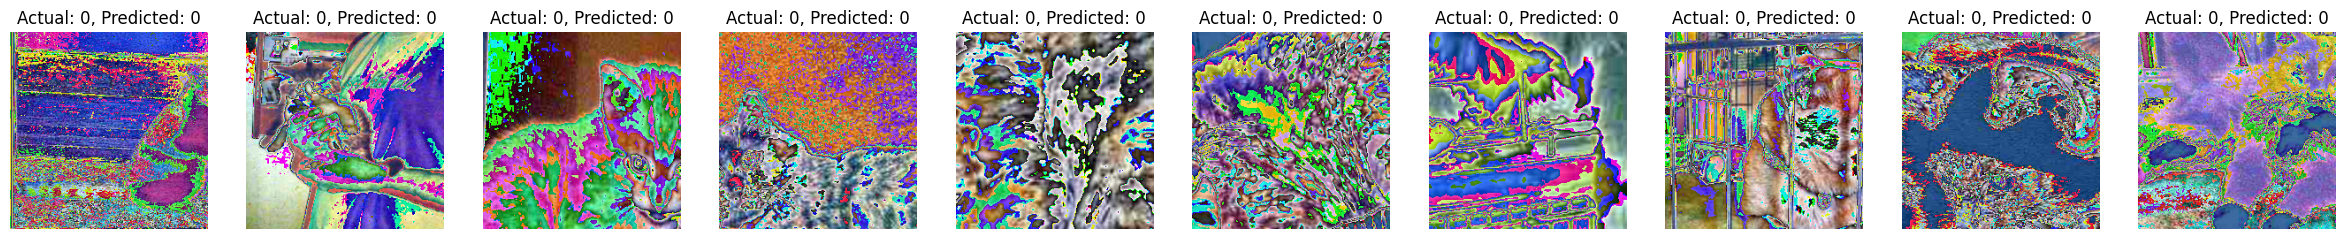

In [28]:
def visualize_predictions(test_dataset, model, device, figsize=(15, 3)):
    model.eval()
    with torch.no_grad():
        fig, axes = plt.subplots(1, 10, figsize=figsize)

        for i in range(10):
            image, label = test_dataset[i]
            image = image.unsqueeze(0).to(device)

            output = model(image)
            _, predicted_label = torch.max(output, 1)
            predicted_label = predicted_label.item()  # Convert tensor to Python integer

            axes[i].imshow(transforms.ToPILImage()(image.squeeze()), cmap='gray')
            axes[i].set_title(f"Actual: {label}, Predicted: {predicted_label}")
            axes[i].axis('off')

        plt.show()

# Example usage with custom figsize
visualize_predictions(test_dataset, model, device, figsize=(30, 8))